In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

ds = pd.read_csv('/kaggle/input/2021spring-cs145-ucla-covid19-prediction/train_trendency.csv')
#ds.head()

sub = pd.read_csv('/kaggle/input/2021spring-cs145-ucla-covid19-prediction/submission.csv')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2021spring-cs145-ucla-covid19-prediction/train_vaccine.csv
/kaggle/input/2021spring-cs145-ucla-covid19-prediction/submission.csv
/kaggle/input/2021spring-cs145-ucla-covid19-prediction/test.csv
/kaggle/input/2021spring-cs145-ucla-covid19-prediction/train_trendency.csv


In [2]:
df = ds[['Province_State','Date','Confirmed','Deaths']]
df.tail()

,Province_State,Date,Confirmed,Deaths
3945,Virginia,03-31-2021,618976,10252
3946,Washington,03-31-2021,364486,5247
3947,West Virginia,03-31-2021,141738,2676
3948,Wisconsin,03-31-2021,636041,7315
3949,Wyoming,03-31-2021,56310,700


In [3]:
#split data by state into seperate dataframes
states = []
for i in range(0,50):
    state_name = df.iloc[i].Province_State
    states.append(df[df.Province_State == state_name])
states[49].head()

,Province_State,Date,Confirmed,Deaths
49,Wyoming,01-12-2021,48072,522
99,Wyoming,01-13-2021,48289,522
149,Wyoming,01-14-2021,48701,522
199,Wyoming,01-15-2021,48909,522
249,Wyoming,01-16-2021,49068,522


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

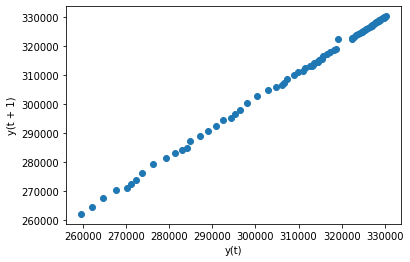

In [4]:
con = states[3][['Date','Confirmed','Deaths']]
#type(con.astype('float32'))
#con.plot()
lag_plot(con['Confirmed'])

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller

Learned about AR concepts and some tools to apply them here:
https://towardsdatascience.com/time-series-forecasting-with-autoregressive-processes-ba629717401

In [6]:
#Confirm that data is stationary
adfuller_res = adfuller(con['Confirmed'])
print(adfuller_res[0])
print(adfuller_res[1])
[7,]

-11.17775020600579
2.545692368195445e-20


[7]

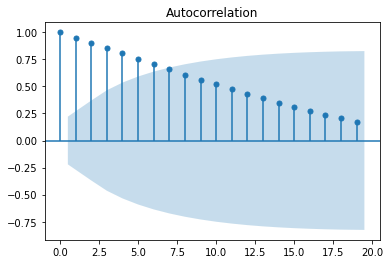

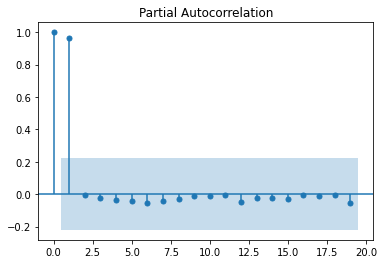

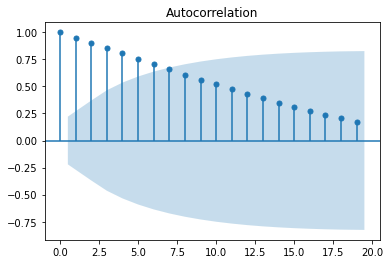

In [7]:
#use plots to determine best lag
state_index = 3
plot_pacf(states[state_index]['Deaths'])
plot_acf(states[state_index]['Deaths'])

In [8]:
#use yule_walker equation to determine rho and sigma for each state
def rho_sigma_list(data, col_name, lag):
    rho_list = []
    sigma_list = []
    for i in range(0, 50):
        curr_rho, curr_sigma = yule_walker(data[i][col_name], lag)
        rho_list.append(curr_rho)
        sigma_list.append(curr_sigma)
    
    return [rho_list, sigma_list]

In [9]:
confirmed_rho_sigma = rho_sigma_list(states, 'Confirmed', 3)
death_rho_sigma = rho_sigma_list(states, 'Deaths', 3)

confirmed_rho_list = confirmed_rho_sigma[0]
confirmed_sigma_list = confirmed_rho_sigma[1]

death_rho_list = death_rho_sigma[0]
death_sigma_list = death_rho_sigma[1]

In [10]:
#use rho and sigma to generate prediction based on given points
def get_AR(rho, sigma, points):
    
    r_len = len(rho)
    if r_len != len(points):
        print('ERROR: incorrect number of points')
        return -1
    
    ans = 0
    for i in range(0, r_len):
        ans = ans + points[i] * rho[i]
    
    return ans + sigma

In [11]:
#generate dataframe with predictions based on rho, sigma, and training data
def df_AR(rho, sigma, prev_data, ans_len):

    ans = []
    #init prev points with last len(rho) points in df
    prev_data = prev_data.tolist()
    prev_points = prev_data[(len(prev_data)-len(rho)):len(prev_data)]
    prev_points.reverse()
    
    for i in range(0,ans_len):
        #get current AR val for current index
        curr_AR_val = get_AR(rho, sigma, prev_points)
        ans.append(curr_AR_val)
        #shift prev_data and update 0th index
        for j in range(1,len(rho)):
            prev_points[j] = prev_points[j-1]
        prev_points[0] = curr_AR_val
    
    return ans

In [12]:
predicted_confirmed = []
predicted_deaths = []
#generate prediction dataframes for each state
for i in range(0, 50):
    
    rho = confirmed_rho_list[i]
    sigma = confirmed_sigma_list[i]
    predicted_confirmed.append(pd.Series(df_AR(rho, sigma, states[i]['Confirmed'], 30)))
    
    rho = death_rho_list[i]
    sigma = death_sigma_list[i]
    predicted_deaths.append(pd.Series((df_AR(rho, sigma, states[i]['Deaths'], 30))))
    
predicted_deaths[48].tail()

25    4826.113740
26    4771.116022
27    4718.176511
28    4667.218182
29    4618.166890
dtype: float64

In [13]:
#combine state dataframes into submission format
state_index = 0
day_index = -1

for i in range(0,1500):
    if i%50 == 0:
        day_index += 1
        
    sub.iloc[i].Confirmed = predicted_confirmed[i%50][day_index]
    sub.iloc[i].Deaths = predicted_deaths[i%50][day_index]

In [14]:
#write to submission file
sub.to_csv("/kaggle/working/submission_lag_3.csv",index=False)
print(sub)

        ID  Confirmed  Deaths
0        0     505224   10630
1        1      61794     307
2        2     820844   16941
3        3     323639    5518
4        4    3562902   59589
...    ...        ...     ...
1495  1495     476509   13256
1496  1496     240406    4566
1497  1497      87841    2265
1498  1498     301370    4618
1499  1499      27049     522

[1500 rows x 3 columns]
